<font size="5">Import Libraries</font>

In [8]:
# Use tensorflow 2.x version

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

<font size="5">Import Dataset</font>

In [9]:
def create_dataset(dataset, look_back=1):
	X = []
	Y = []
	
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		X.append(a)
		Y.append(dataset[i + look_back, 0])
	
	return np.array(X), np.array(Y)

np.random.seed(7)

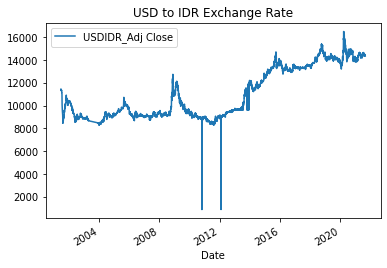

In [10]:
dataset = data = pd.read_csv("./USDIDR_series.csv", index_col="Date")
dataset.index = pd.to_datetime(dataset.index)
dataset = dataset[["USDIDR_Adj Close"]]
dataset = dataset.sort_index()
data = data.sort_index()

dataset.plot()
plt.title("USD to IDR Exchange Rate")
plt.show()

In [11]:
averageClosingPrice = np.average(dataset)
print(f"Average Closing Price: {averageClosingPrice}")

Average Closing Price: 11067.873790581705


<font size="5">Data Preprocessing & Splitting</font>

In [12]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train = dataset[0:train_size,:]
test = dataset[train_size:len(dataset),:]

look_back = 1
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [15]:
AverageTrainClosingPrice = np.average(Y_train)
AverageTestClosingPrice = np.average(Y_test)

print(f"Average Train Dataset Closing Price: {AverageTrainClosingPrice}")
print(f"Average Test Dataset Closing Price: {AverageTestClosingPrice}")

Average Train Dataset Closing Price: 10269.033240183144
Average Test Dataset Closing Price: 14259.966608176668


<font size="5">Model Creation & Training</font>

In [13]:
epochs = 10
model = Sequential()

model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam")
model.fit(X_train, Y_train, epochs=epochs, batch_size=1, verbose=2)

trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)

Y_train = scaler.inverse_transform([Y_train])
Y_test = scaler.inverse_transform([Y_test])

trainRMSE = math.sqrt(mean_squared_error(Y_train[0], trainPredict[:,0]))
testRMSE = math.sqrt(mean_squared_error(Y_test[0], testPredict[:,0]))

print()
print(f'Train RMSE: {trainRMSE}')
print(f'Test RMSE: {testRMSE}')

Epoch 1/10
4022/4022 - 4s - loss: 0.0159
Epoch 2/10
4022/4022 - 4s - loss: 4.9328e-04
Epoch 3/10
4022/4022 - 3s - loss: 3.2194e-04
Epoch 4/10
4022/4022 - 4s - loss: 3.2002e-04
Epoch 5/10
4022/4022 - 4s - loss: 3.1839e-04
Epoch 6/10
4022/4022 - 5s - loss: 3.1504e-04
Epoch 7/10
4022/4022 - 4s - loss: 3.1291e-04
Epoch 8/10
4022/4022 - 4s - loss: 3.1367e-04
Epoch 9/10
4022/4022 - 5s - loss: 3.0792e-04
Epoch 10/10
4022/4022 - 5s - loss: 3.0550e-04

Train RMSE: 261.6276307245367
Test RMSE: 116.4896965091589


<font size="5">Model Testing</font>

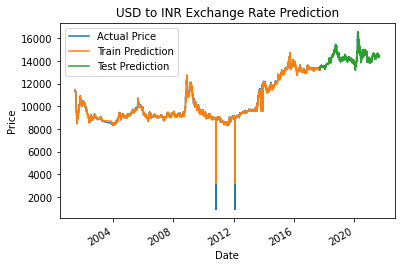

In [14]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[ : , : ] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, : ] = trainPredict

testPredictPlot = np.empty_like(dataset)
testPredictPlot[ : , : ] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, : ] = testPredict

data["USDIDR_Adj Close"].plot(label="Actual Price")
plt.plot(data.index, trainPredictPlot, label="Train Prediction")
plt.plot(data.index, testPredictPlot, label="Test Prediction")
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("USD to INR Exchange Rate Prediction")
plt.legend()
plt.show()